In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (7, 5)

In [40]:
train_df = pd.read_csv("../data/train.csv")
print(f"Loaded: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
display(train_df.head(3))
train_df.info()

Loaded: 1460 rows, 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [41]:
to_drop = [i for i in [523, 1298] if i in train_df.index]
if to_drop:
    print(f"Removing outlier rows (by index): {to_drop}")
    train_df = train_df.drop(index=to_drop).reset_index(drop=True)
else:
    print("Outlier rows (523, 1298) not present or already removed.")

Removing outlier rows (by index): [523, 1298]


In [ ]:
y = np.log1p(train_df["SalePrice"]).values  # SalePriceLog # type: ignore
X = train_df.drop(columns=["SalePrice"])

In [44]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
print(f"# numeric: {len(numeric_features)}, # categorical: {len(categorical_features)}")

# numeric: 37, # categorical: 43


In [45]:
# Preprocessing Pipelines
# - Numeric: median impute + standardize
# - Categorical: most_frequent impute + one-hot (ignore unknown)
# Handle OneHotEncoder API diff across sklearn versions:
#   prefer sparse_output=False (>=1.2), else fallback to sparse=False
# -----------------------------
ohe_kwargs = {}
try:
    # sklearn >=1.2
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    # older versions
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    n_jobs=None
)

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(f"Split: X_train={X_train.shape}, X_valid={X_valid.shape}")

Split: X_train=(1166, 80), X_valid=(292, 80)


In [47]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_and_evaluate(name, estimator, X_train, y_train, X_valid, y_valid):
    """Fit pipeline(preprocessor+model), return metrics + fitted pipeline."""
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", estimator)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    out = {
        "name": name,
        "rmse": rmse(y_valid, y_pred),
        "mae": mean_absolute_error(y_valid, y_pred),
        "r2": r2_score(y_valid, y_pred),
        "pipeline": pipe,
    }
    print(f"[{name:<24}] RMSE={out['rmse']:.4f} | MAE={out['mae']:.4f} | R2={out['r2']:.4f}")
    return out


In [48]:
# baseline models
results = []
results.append(fit_and_evaluate("LinearRegression",
                                LinearRegression(),
                                X_train, y_train, X_valid, y_valid))

results.append(fit_and_evaluate("Ridge(alpha=1.0)",
                                Ridge(alpha=1.0, random_state=RANDOM_STATE),
                                X_train, y_train, X_valid, y_valid))

results.append(fit_and_evaluate("Lasso(alpha=0.001)",
                                Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=10000),
                                X_train, y_train, X_valid, y_valid))

results.append(fit_and_evaluate("ElasticNet(a=0.001,l1=0.5)",
                                ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000),
                                X_train, y_train, X_valid, y_valid))

results.append(fit_and_evaluate("DecisionTree(max_depth=10)",
                                DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
                                X_train, y_train, X_valid, y_valid))

results.append(fit_and_evaluate("RandomForest(200,depth=12)",
                                RandomForestRegressor(
                                    n_estimators=200, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1
                                ),
                                X_train, y_train, X_valid, y_valid))


[LinearRegression        ] RMSE=0.1344 | MAE=0.0917 | R2=0.8929
[Ridge(alpha=1.0)        ] RMSE=0.1250 | MAE=0.0866 | R2=0.9074
[Lasso(alpha=0.001)      ] RMSE=0.1185 | MAE=0.0837 | R2=0.9167
[ElasticNet(a=0.001,l1=0.5)] RMSE=0.1172 | MAE=0.0834 | R2=0.9185
[DecisionTree(max_depth=10)] RMSE=0.2029 | MAE=0.1464 | R2=0.7557
[RandomForest(200,depth=12)] RMSE=0.1441 | MAE=0.0969 | R2=0.8768


In [49]:
summary_df = pd.DataFrame([{k: v for k, v in r.items() if k != "pipeline"} for r in results]) \
               .sort_values("rmse", ascending=True)
display(summary_df)

,name,rmse,mae,r2
3,"ElasticNet(a=0.001,l1=0.5)",0.117197,0.083406,0.918522
2,Lasso(alpha=0.001),0.118512,0.083737,0.916684
1,Ridge(alpha=1.0),0.124952,0.086632,0.907382
0,LinearRegression,0.134368,0.091724,0.892899
5,"RandomForest(200,depth=12)",0.144089,0.096868,0.876840
4,DecisionTree(max_depth=10),0.202946,0.146350,0.755676


In [50]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

def cross_val_report(name, estimator):
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", estimator)])
    scores = cross_validate(
        pipe,
        X, y,
        scoring=("neg_mean_squared_error", "neg_mean_absolute_error", "r2"),
        cv=cv,
        n_jobs=-1,
        return_train_score=True
    )
    rmse_test = np.sqrt(-scores["test_neg_mean_squared_error"])
    mae_test  = -scores["test_neg_mean_absolute_error"]
    r2_test   = scores["test_r2"]

    print(f"[CV] {name:<25} RMSE={rmse_test.mean():.4f}±{rmse_test.std():.4f} | "
          f"MAE={mae_test.mean():.4f}±{mae_test.std():.4f} | R2={r2_test.mean():.4f}±{r2_test.std():.4f}")
    return scores

cv_scores_ridge = cross_val_report("Ridge(alpha=1.0)", Ridge(alpha=1.0, random_state=RANDOM_STATE))
cv_scores_rf    = cross_val_report("RandomForest(200,depth=12)",
                                   RandomForestRegressor(n_estimators=200, max_depth=12,
                                                         random_state=RANDOM_STATE, n_jobs=-1))

[CV] Ridge(alpha=1.0)          RMSE=0.1187±0.0087 | MAE=0.0822±0.0039 | R2=0.9111±0.0125
[CV] RandomForest(200,depth=12) RMSE=0.1391±0.0074 | MAE=0.0959±0.0044 | R2=0.8776±0.0169


In [51]:
def plot_learning_curve(estimator, title):
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", estimator)])
    sizes, train_scores, valid_scores = learning_curve(
        pipe, X, y, cv=5, scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1, random_state=RANDOM_STATE
    )
    # Convert to RMSE
    train_rmse = np.sqrt(-train_scores)
    valid_rmse = np.sqrt(-valid_scores)

    plt.figure()
    plt.plot(sizes, train_rmse.mean(axis=1), marker="o", label="Train RMSE")
    plt.plot(sizes, valid_rmse.mean(axis=1), marker="o", label="Validation RMSE")
    plt.fill_between(sizes,
                     train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                     train_rmse.mean(axis=1) + train_rmse.std(axis=1), alpha=0.15)
    plt.fill_between(sizes,
                     valid_rmse.mean(axis=1) - valid_rmse.std(axis=1),
                     valid_rmse.mean(axis=1) + valid_rmse.std(axis=1), alpha=0.15)
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE (log SalePrice)")
    plt.legend()
    plt.grid(True)
    plt.show()

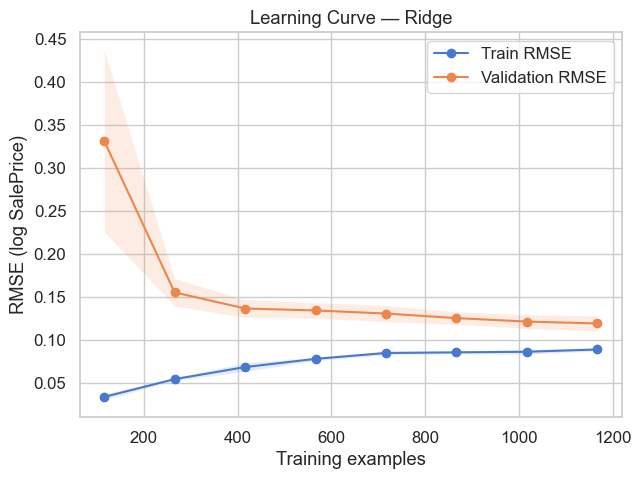

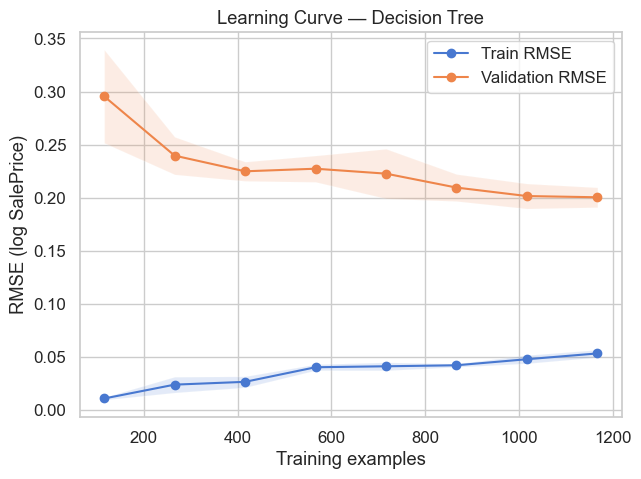

In [52]:
plot_learning_curve(Ridge(alpha=1.0, random_state=RANDOM_STATE), "Learning Curve — Ridge")
plot_learning_curve(DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE), "Learning Curve — Decision Tree")